# CSE5CV - Pedestrian Tracking

In this lab we will create and use a pedestrian tracking algorithm.

By the end of this lab, you should be able to:
* Describe "Association" in the context of tracking
* Understand the Linear Assignment Problem and it's relevance to tracking
* Understand how you can use Mask RCNN with a simple tracking algorithm

Evaluating tracking results is left to the reader.

## Colab preparation

Google Colab is a free online service for editing and running code in notebooks like this one. To get started, follow the steps below:

1. Click the "Copy to Drive" button at the top of the page. This will open a new tab with the title "Copy of...". This is a copy of the lab notebook which is saved in your personal Google Drive. **Continue working in that copy, otherwise you will not be able to save your work**. You may close the original Colab page (the one which displays the "Copy to Drive" button).
2. Run the code cell below to prepare the Colab coding environment by downloading sample files. Note that if you close this notebook and come back to work on it again later, you will need to run this cell again.

In [1]:
!git clone https://github.com/ltu-cse5cv/cse5cv-labs.git
%cd cse5cv-labs/Lab07

Cloning into 'cse5cv-labs'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 173 (delta 59), reused 150 (delta 36), pack-reused 0
Receiving objects: 100% (173/173), 30.04 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/cse5cv-labs/Lab07


## Packages

In [2]:
import copy
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf

# 1. Brief disambiguation

In this lab, we will use many terms, some with similar yet distinct meanings. Here we provide a disambiguation between these terms.

**detection**: A detection is a single pair of coordinates or bounding box.

**track**: A track is a construct in our code containing a list of detections. There can only ever be a single detection per frame of video per track. In this lab, it will take the form of a dictionary with two keys: `start_frame` and (`points` or `boxes`). Then `points[i]` is the `i`-th prediction of the track, and it was made on `start_frame+i`.

**individual**: An individual is a physical object which is being imaged and tracked.

**identity**: A track has a single identity. The identity is the predicted continuity of an individual through time created by collecting detections into a track. That is, if our tracking algorithm is not perfect, it may, in fact, describe the path of multiple individuals throughout the track. This type of error is called an "identity swap".

**online algorithm**: An online algorithm is one which processes data linearly, in the order which it appears. Here, we mean that the algorithm will first consider all the detections on frame 1. Then it will consider all the detections on frame 2, and how they can link up. Then it will consider all the detections on frame 3, etc. This is in contrast to a "global algorithm" which would consider all the detections on all the frames all at the same time.

**open**/**closed**: In an online tracking algorithm, when an individual is no longer being tracked, their track is marked as "closed" and won't be considered when choosing which tracks to add detections to. A track will be closed when we can no longer find detections to match it. This will happen if the individual goes out of frame or gets obscured by other things in the scene. The tracks which are actively being considered to add points to are called "open" tracks.

**association**: In concept: We "associate" a detection with an identity. In code: On every frame of the video, we "associate" each detection with at most one of the open tracks. Some detections or tracks will not be associated if there is an unbalanced number of either.

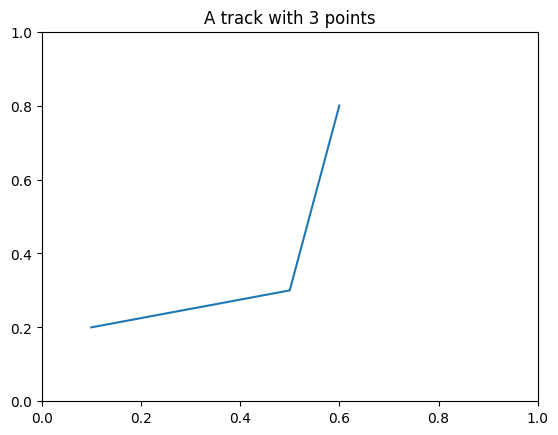

In [3]:
# Some examples in code:
# Detections
#  - Using points (x,y)
point1 = [0.1, 0.2]
point2 = [0.5, 0.3]
point3 = [0.6, 0.8]
#  - Using boxes (tlx, tly, brx, bry)
box1 = [0.1, 0.1, 0.2, 0.2]
box2 = [0.3, 0.1, 0.5, 0.15]

# Track
#  - Using Points
points = [point1, point2, point3]
point_track = {'start_frame': 0, 'points': points}
#  - Using Boxes
boxes = [box1, box2]
box_track = {'start_frame': 0, 'boxes': boxes}

# Plot the point_track
def xy_separate(seq):
    '''
    Given a (seq)uence of [[x, y], [x, y], [x, y], ...] coordinates
    separate them into two tuples (x, x, x, ...), (y, y, y, ...)
    '''
    return zip(*seq)

fig, ax = plt.subplots(1, 1)
x, y = xy_separate(point_track['points'])
ax.plot(x, y)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
_ = ax.set_title(f'A track with {len(points)} points')

# 2. Tracking

A tracking algorithm, in the context of video, is one which describes the path of an individual person/object within the video. There are two main approaches taken:
1. **A "tracker"**: A "tracker" is an algorithm that uses the location of an object on frame `i`, and finds where that object is in frame `i+1`. Determining the initial position is usually done with an object detector on the first frame of the video, and then the "tracker" runs through the video, updating the location. This method does not extend well to multi-object tracking, where different objects come in and out of frame.
2. **Tracking by detection**: There has been a lot of research into creating good object detectors. A video consists of many frames (images). So, if we run a very good object detector on each frame, then it is simply a matter of choosing which detections belong together. Tracking by detection typically runs much faster because it only looks at point data, rather than image data. This method's performance is limited by the performance of the object detector, but tends to be simpler to implement.

We will use **Tracking by detection** in this lab as it is simpler for multi-object tracking and is more popular these days.

# 3. Detections

We will use MaskRCNN to produce the detections used for tracking. Since processing the whole video takes a long time, we have already written and run `get_detections` on the whole video and stored the result in `'./mot20-01-det.th'` for your convenience. Make sure you read and understand the code used:

```python
# From Lab 4
def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

# class_index==1 is person
def get_detections(maskrcnn, vid, score_threshold=0.5, class_index=1):
    ''' Runs maskrcnn over all frames in vid, storing the detections '''
    # Record how long the video is (in frames)
    vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Read the frame on which the video was previously
    initial_frame = int(vid.get(cv2.CAP_PROP_POS_FRAMES))
    
    # Set the video the frame 0
    vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # For each frame, read it, give it to maskrcnn and record the boxes
    det = []
    for i in range(vid_length):
        _, img = vid.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        with torch.no_grad():
            result = maskrcnn(preprocess_image(img))[0]
        # Only check for one class
        mask1 = result["labels"] == class_index
        # And only if the model is confident enough about it
        mask2 = result["scores"] > score_threshold
        mask = mask1 & mask2

        boxes = result["boxes"][mask].detach().cpu().numpy()
        det.append(boxes)
        print(f'{i+1:0d}/{vid_length}')

    # Set the video back to the frame it was before we started
    vid.set(cv2.CAP_PROP_POS_FRAMES, initial_frame)
    
    return det

maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()
vid = cv2.VideoCapture('./mot20-01.mp4')
all_detections = get_detections(maskrcnn, vid, score_threshold=0.3)
torch.save(all_detections, './mot20-01-det.th')
```

In [4]:
all_detections = torch.load('./mot20-01-det.th')

## 3.1 Visualise

We will do a sanity check to see how well MaskRCNN has detected the people.

**Task**: Use the `cv2.VideoCapture` class (shown in the above code) to grab frames `[0, 10, 20, 30]` and the provided `draw_detections()` function to put boxes around all detected objects. Then draw each of these frames using `plt.imshow()`

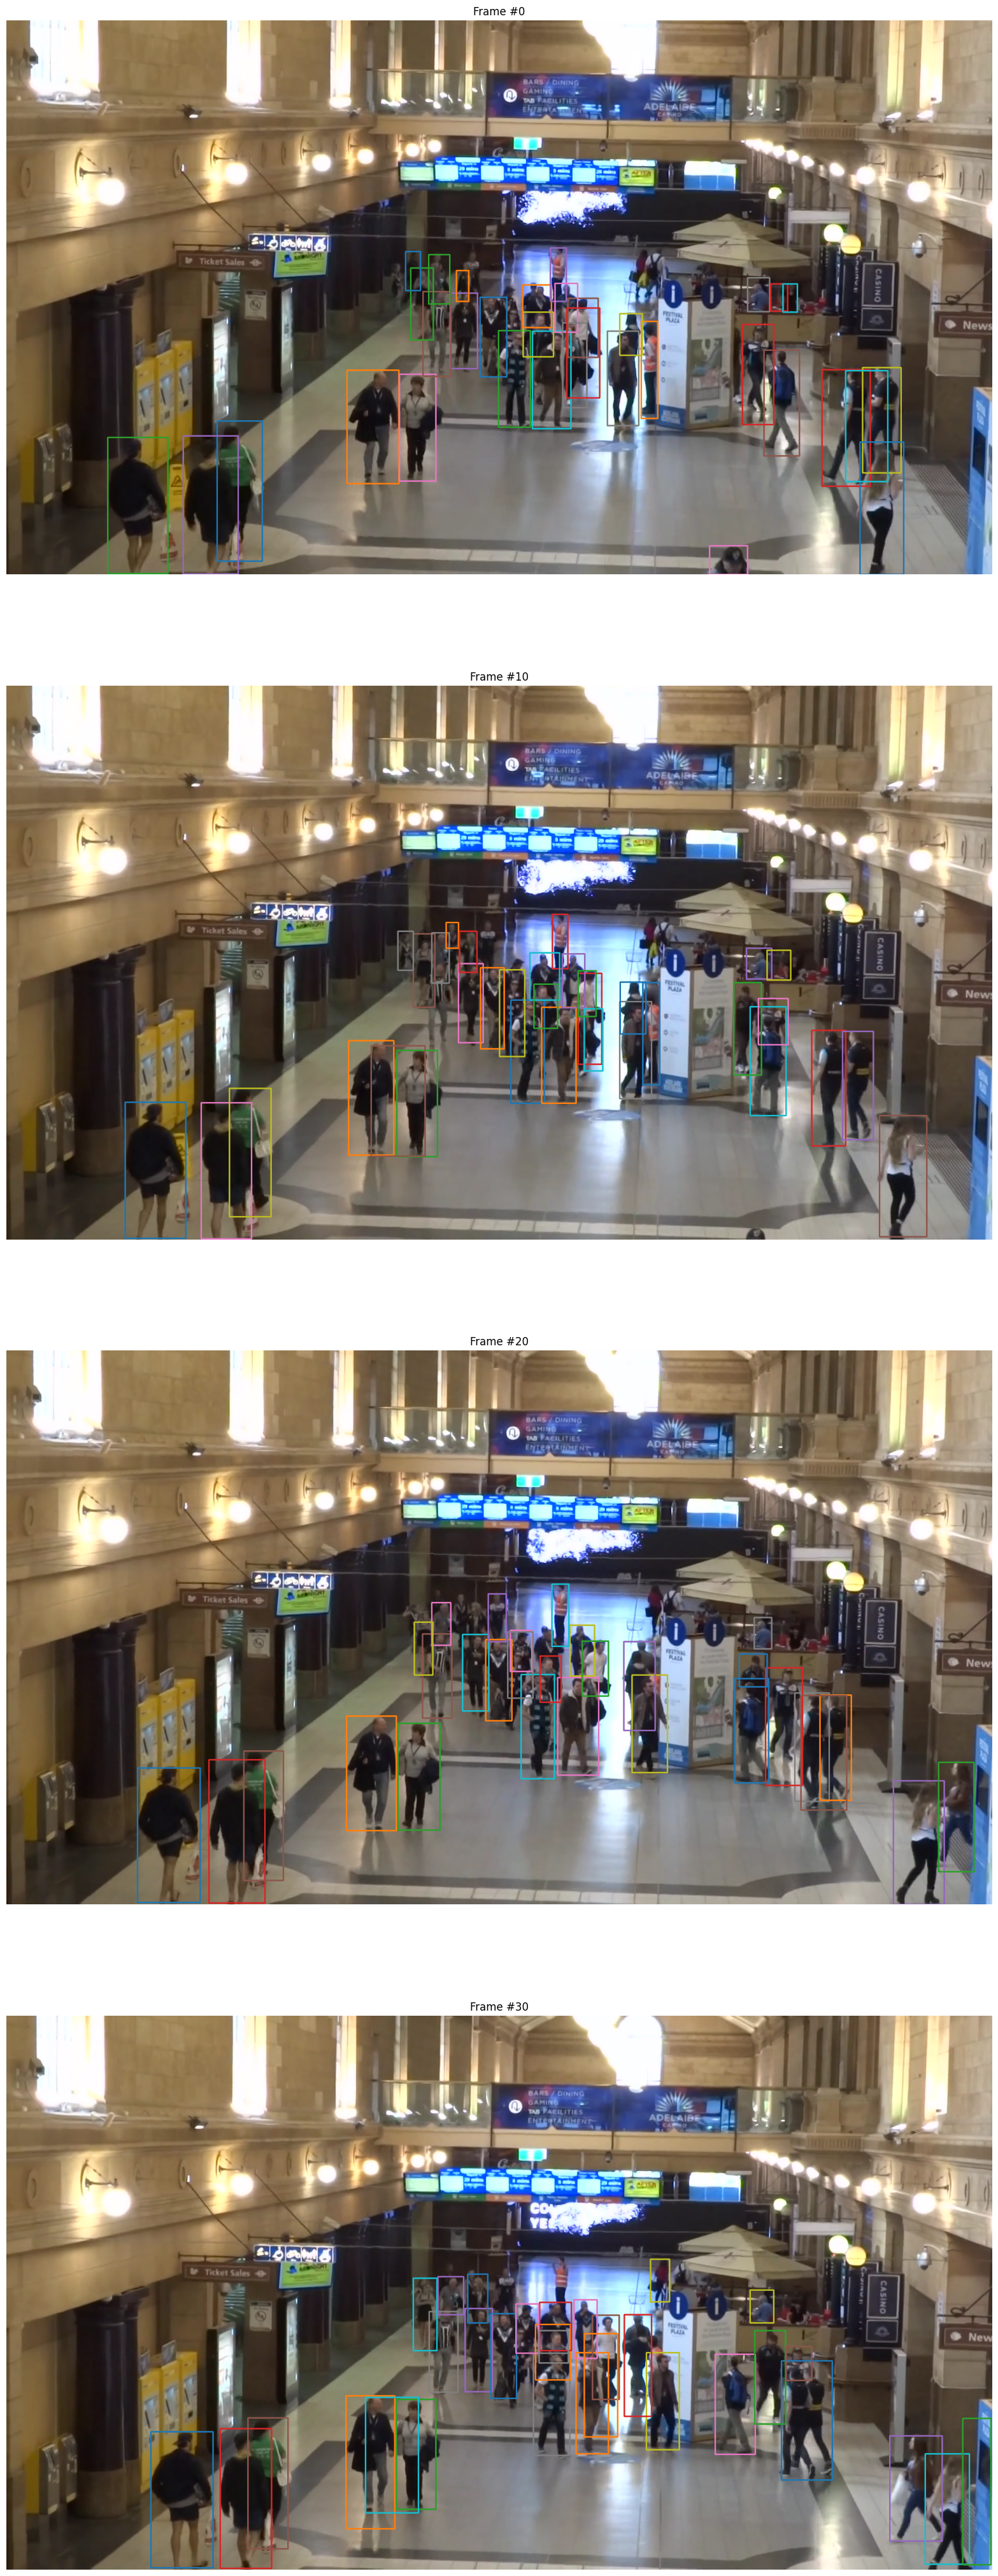

In [6]:
# From Lab 4 (with small modification; draw_detections no longer expects class predictions)
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]
def draw_detections(img, det, colours=COLOURS):
    for i, (tlx, tly, brx, bry) in enumerate(det):
        i %= len(colours)
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)


#@title Task solution

# TODO: open video with cv2.VideoCapture
vid = cv2.VideoCapture('./mot20-01.mp4')

fig, axes = plt.subplots(n_rows, 1, figsize=(22, 13*n_rows))
for idx, fr_num in enumerate(frame_numbers):
    # TODO: Set vid to frame i
    vid.set(cv2.CAP_PROP_POS_FRAMES, fr_num)

    # TODO: Read a frame
    _, img = vid.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # TODO: Get detections for frame i out of all_detections
    det = all_detections[fr_num]

    # TODO: Change det to the np.int32 dtype
    det = det.astype(np.int32)

    # TODO: Draw on img
    draw_detections(img, det)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Frame #{fr_num}')
plt.savefig('./detections.png')




In [ ]:
#@title Task solution

# TODO: open video with cv2.VideoCapture
vid = cv2.VideoCapture('./mot20-01.mp4')

fig, axes = plt.subplots(n_rows, 1, figsize=(22, 13*n_rows))
for idx, fr_num in enumerate(frame_numbers):
    # TODO: Set vid to frame i
    vid.set(cv2.CAP_PROP_POS_FRAMES, fr_num)

    # TODO: Read a frame
    _, img = vid.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # TODO: Get detections for frame i out of all_detections
    det = all_detections[fr_num]

    # TODO: Change det to the np.int32 dtype
    det = det.astype(np.int32)

    # TODO: Draw on img
    draw_detections(img, det)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Frame #{fr_num}')
plt.savefig('./detections.png')

**Question**: Looking at the three people in the bottom left of the frames. They are all consistently detected across frames. However, their boxes are drawn in different colours on each frame. Why is this?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
We don't actually know that these detections belong to the same people, yet. All we know is that MaskRCNN told us where a bunch of people were on each frame. More specifically, remember that MaskRCNN orders it's predictions by confidence (score), and <code>draw_detections</code> just assigns the colour by the order.
</details>
<br/>

**Question**: Can you see any false negatives in the above image? What about false positives?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
A false negative is where there is actually a person, but MaskRCNN did not detect them. There are several examples of this on each frame at the very back, where it seems the people are too small to be detected reliably.

A false positive is where MaskRCNN predicted a person, but there wasn't one. It's hard to spot, but there is at least one false positive on the middle of the right-hand-side of the image for all of the frames.
</details>

# 4. Association

The process by which we determine that a point/bounding box belongs to a track is called "association". There are two steps in associating tracks with detections:

1. Measure cost.
2. Choose pairings between detection and track with minimal cost.

## 4.1 Measure Cost

The first step of association is measuring the cost of adding each detection to each track. Depending on your data, there may be different ways to measure how well a detection fits with an existing track. In the below code cell, we define two tracks and two detections. We're going to use a bit of intuition here, then go through exact methods after.

In [7]:
detections = [
    [0.7, 0.7],
    [0.1, 0.1],
    [2.5, 2.1],
    [5.2, 7.7]
]

tracks = [
    {'start_frame': 0, 'points': [
        [0.25, 0.25],
        [0.20, 0.20],
        [0.15, 0.15]
    ]},
    {'start_frame': 0, 'points': [
        [0.55, 0.55],
        [0.60, 0.60],
        [0.65, 0.65],
    ]},
    {'start_frame': 0, 'points': [
        [2.8, 2.4],
        [2.7, 2.3],
        [2.6, 2.2],
    ]}
]

**Question**: Are the `detections` above points or boxes?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
A single video frame has a width and a height. A pair of coordinates has an x and a y. An axis-aligned box is represented with 4 numbers. Thus, the <code>detections</code> are points, as there is only one pair of coordinates per detection.
</details>
<br />

**Question**: What is the frame number of the hypothetical video frame that these `detections` are for?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
All tracks start at frame 0, and have 3 points (for frames [0,1,2]), thus the current <code>detections</code> are for frame 3.
</details>
<br />

**Question**: Which detection belongs with which track? i.e. Should `detections[0]` be associated with `tracks[0]`, `tracks[1]` or `tracks[2]`?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

We are looking for a next point in each track which continues the existing pattern. We can see that `tracks[1]` is increasing linearly towards `detections[0]`. Thus we would say that we should associate `detections[0]` with `tracks[1]`. And similarly from `tracks[0]` to `detections[1]`, etc.
</details>
<br />

**Task**: Add the detections to the tracks as per the answer to the above question.

In [8]:


#@title Task solution

# Make a copy so we don't mess with the original
tracks_copy = copy.deepcopy(tracks)

tracks_copy[1]['points'].append(detections[0])
tracks_copy[0]['points'].append(detections[1])

print(tracks_copy[0]['points'])
print(tracks_copy[1]['points'])
assert len(tracks_copy[0]['points']) == 4
assert len(tracks_copy[1]['points']) == 4



[[0.25, 0.25], [0.2, 0.2], [0.15, 0.15], [0.1, 0.1]]
[[0.55, 0.55], [0.6, 0.6], [0.65, 0.65], [0.7, 0.7]]


In [ ]:
#@title Task solution

# Make a copy so we don't mess with the original
tracks_copy = copy.deepcopy(tracks)

tracks_copy[1]['points'].append(detections[0])
tracks_copy[0]['points'].append(detections[1])

print(tracks_copy[0]['points'])
print(tracks_copy[1]['points'])
assert len(tracks_copy[0]['points']) == 4
assert len(tracks_copy[1]['points']) == 4

### 4.1.1 Point-point distance

The simplest cost is the Euclidean distance between the last point of the track and the detected point. We can easily do this with the [`np.linalg.norm()` function](https://numpy.org/doc/1.20/reference/generated/numpy.linalg.norm.html).

*Note*: Euclidean distance and L2 norm are the same thing.

**Task**: Calculate the distance between `p1` and `p2` with basic arithmetic operators (e.g. `+`, `-`, `*`, `/`, `**`). Separately, use the [`np.linalg.norm()` function](https://numpy.org/doc/1.20/reference/generated/numpy.linalg.norm.html) to calculate the distance, and compare.

In [9]:
p1 = [0.10, 0.10]
p2 = [0.15, 0.15]
diff = np.array(p2)-np.array(p1)

# TODO: Calculate manually
# dist_manual = ...
# print(dist_manual)

# TODO: Calculate using np.linalg.norm
# dist_np = ...
# print(dist_np)

In [ ]:
#@title Task solution

# TODO: Calculate manually
dist_manual = (diff[0]**2 + diff[1]**2)**0.5
print(dist_manual)

# TODO: Calculate using np.linalg.norm
dist_np = np.linalg.norm(diff)
print(dist_np)

Now that we know a concrete method for determining a cost of joining tracks and points...

**Task**: Calculate the euclidean distance from `detections[0]` to the ends of both `tracks[0]` and `tracks[1]` using `np.linalg.norm()`.

In [10]:
diff00 = np.array(detections[0])-np.array(tracks[0]['points'][-1])
diff01 = np.array(detections[0])-np.array(tracks[1]['points'][-1])

#@title Task solution

dist00 = np.linalg.norm(diff00)
dist01 = np.linalg.norm(diff01)

print(dist00)
print(dist01)

0.7778174593052022
0.07071067811865465


In [ ]:
#@title Task solution

dist00 = np.linalg.norm(diff00)
dist01 = np.linalg.norm(diff01)

print(dist00)
print(dist01)

We can see that the euclidean distance between `detections[0]` and `tracks[1]` is the smaller value. This tells us that `detections[0]` should be added to `tracks[1]`, just like the intuition.

#### Vectorisation

In this case we have four detections and three tracks, and we need to compare each detection with each track.

**Question**: How many distances will we need to calculate to compare all detections with all tracks?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
We will need to calculate 12 different distances. For every detection (4), we must measure the distance with every track (3), so there are (4*3=12) different distances to compare. We will typically store these as a <code>np.array</code> shaped <code>[4, 3]</code>
</details>
<br/>

We would like to write code that can compare an arbitrary number of detections and tracks with minimal code. We could write a for loop, but we can avoid that by using [broadcasting](https://numpy.org/doc/1.20/user/basics.broadcasting.html) in numpy. This is called "vectorisation" and runs significantly faster than using a for-loop. In the code cell below, we show finding a difference between all detections and all tracks using broadcasting.

<details>
<summary style='cursor:pointer;'><u>Extra details: Using <code>arr[None]</code></u></summary>

In numpy, using a `None` in the index inserts a singleton dimension at that position. e.g. if `arr` is shaped `[3,4,5]` then `arr[:, None]` is shaped `[3,1,4,5]`. It is a shorthand for using something like [np.reshape()](https://numpy.org/doc/1.21/reference/generated/numpy.reshape.html) or [np.expand_dims()](https://numpy.org/doc/1.21/reference/generated/numpy.expand_dims.html) to insert that singleton dimension.
</details>

In [11]:
detections_np = np.array(detections)
# A numpy array of the last point in each track
previous_np = np.array([t['points'][-1] for t in tracks])

print('Shapes before')
print(detections_np.shape)
print(previous_np.shape)

detections_np_expanded = detections_np[:, None]
previous_np_expanded = previous_np[None]

print('Shapes after expanding')
print(detections_np_expanded.shape)
print(previous_np_expanded.shape)

diff = detections_np_expanded - previous_np_expanded

print('Shape of diff')
print(diff.shape)

# This is a common numpy pattern. The above code is typically done in one line:
diff = detections_np[:, None] - previous_np[None]
print(diff.shape)

Shapes before
(4, 2)
(3, 2)
Shapes after expanding
(4, 1, 2)
(1, 3, 2)
Shape of diff
(4, 3, 2)
(4, 3, 2)


**Question**: Notice that the shape of `diff` is `(<n_detections>, <n_tracks>, 2)`. Why is the last dimension 2?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
<code>diff</code> Is a 1D difference in both the <code>x</code> and the <code>y</code>. The last dimension is just the <code>x</code> and the <code>y</code>.
</details>
<br/>

**Question**: By indexing into `diff`. How do we find the difference in the `x` dimension between the `detections[2]` and the `tracks[0]`.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
<code>diff[2, 0, 0]</code>
</details>
<br/>

**Question**: By indexing into `diff`. How do we find the distance between the `detections[2]` and the `tracks[0]`.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
<code>np.linalg.norm(diff[2, 0])</code>
</details>
<br/>

**Task**: And the last step: calculate the distance between all detections and all tracks using `np.linalg.norm()` in a single line of code

In [12]:
# TODO
# dist = ...
dist = np.linalg.norm(diff, axis=-1)
print(dist.shape)
print(dist[2, 0])
print(np.linalg.norm(diff[2, 0]))

(4, 3)
3.0536862969204943
3.0536862969204943


In [ ]:
#@title Task solution

dist = np.linalg.norm(diff, axis=-1)
print(dist.shape)
print(dist[2, 0])
print(np.linalg.norm(diff[2, 0]))

### 4.1.2 Bounding box center distance

Point-point distance measurement is the most common cost metric. It is sometimes preferred to convert bounding boxes into a single point so that we can use Euclidean point-point distance.

**Task**: Convert `boxes` in the below code into a list of points that are the center coordinates of the bounding boxes.

In [13]:
boxes = [
    [0.1, 0.1, 0.2, 0.2],
    [0.3, 0.1, 0.5, 0.15],
    [0.2, 0.6, 0.4, 0.8],
]

# TODO: complete function
def tlbr_to_center(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:

        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append((cx, cy))
    return points

print(tlbr_to_center(boxes))

[(0.15000000000000002, 0.15000000000000002), (0.4, 0.125), (0.30000000000000004, 0.7)]


In [ ]:
#@title Task solution

def tlbr_to_center(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append((cx, cy))
    return points

print(tlbr_to_center(boxes))

### 4.1.3 Bounding box overlap

If we are using bounding boxes, then we can of course simply measure similarity based on the overlap between the boxes. We've done this before.

**Question**: How do we typically measure similarity between bounding boxes?

<details>
<summary style='cursor:pointer;'><u>Answer and next task</u></summary>
We usually use Intersection over Union (IoU) or Dice Coefficient (DSC) to measure similarity between bounding boxes.

**Task**: Use `bbox_iou_matrix()` to measure the similarity between `detections` and `tracks` in the below code.
</details>

In [16]:
# Used in Lab 04
def bbox_iou_matrix(a, b):
    '''
    Vectorised iou calculation for bbox predictions.

    Parameters:
        a (np.array [N, 4]): array of N boxes, each as [tlx, tly, brx, bry]
        b (np.array [M, 4]): as `a`, but with M boxes

    Returns:
        np.array [N, M]: the iou for every pair of boxes.
    '''
    a = a[:, None] # [N, 1, 4]
    b = b[None, :] # [1, M, 4]

    tlx_a, tly_a, brx_a, bry_a = [a[..., i] for i in range(4)]
    tlx_b, tly_b, brx_b, bry_b = [b[..., i] for i in range(4)]

    # Find the overlap/intersection
    # note: np.maximum() != np.max()
    tlx_overlap = np.maximum(tlx_a, tlx_b)
    tly_overlap = np.maximum(tly_a, tly_b)
    brx_overlap = np.minimum(brx_a, brx_b)
    bry_overlap = np.minimum(bry_a, bry_b)
    # Clipping to account for non-overlapping
    intersection = (brx_overlap - tlx_overlap).clip(0) * (bry_overlap - tly_overlap).clip(0)

    area_a = abs((brx_a - tlx_a) * (bry_a - tly_a))
    area_b = abs((brx_a - tlx_a) * (bry_a - tly_a))
    union = area_a + area_b - intersection

    return intersection / union



detections = [
    [0.1, 0.1, 0.2, 0.2],
    [0.3, 0.1, 0.5, 0.2],
    [0.2, 0.5, 0.3, 0.7],
    [0.6, 0.2, 0.9, 0.3],
]

tracks = [
    {'start_frame': 0, 'boxes': [
        [0.08, 0.08, 0.18, 0.18],
        [0.09, 0.09, 0.19, 0.19],
    ]},
    {'start_frame': 0, 'boxes': [
        [0.22, 0.52, 0.32, 0.72],
        [0.21, 0.51, 0.31, 0.71],
    ]},
]

#@title Task solution

detections_np = np.array(detections)
previous_np = np.array([t['boxes'][-1] for t in tracks])

iou = bbox_iou_matrix(detections_np, previous_np)
assert iou.shape == (4,2)

In [ ]:
#@title Task solution

detections_np = np.array(detections)
previous_np = np.array([t['boxes'][-1] for t in tracks])

iou = bbox_iou_matrix(detections_np, previous_np)
assert iou.shape == (4,2)

**Question**: Which `detections` should be associated with which `tracks`? Make your estimation, print out `iou` and check your answer.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

Printing out `iou` gives:

```
[[0.68067227 0.        ]
 [0.         0.        ]
 [0.         0.74672489]
 [0.         0.        ]]
```

This tells us that `detections[0]` should be associated with `tracks[0]`, `detections[2]` should be associated with `tracks[1]`, and the remaining detections are not associated with any track. *Note*: A "cost" should be low to indicate that a detection should be matched with a track. So when using IoU as a cost metric, make sure you use `(1-iou)`.
</details>

### 4.1.4 Appearance features

Technically speaking, tracking by detection is under-defined. In many circumstances there are multiple plausible associations. Sometimes we need to use the information in the actual image to decide how to join. For example, if we see one track is following someone wearing a red shirt and we have two plausible detections, one which covers someone with a green shirt and the other a red shirt, then we can conclude we should join the detection for someone wearing a red shirt to our existing track, even if it's further away.

Following this intuition, we want a systematic way to measure similarity between image patches. We already know that comparing images pixel-by-pixel isn't a good idea.

**Question**: How do we reduce the dimensionality of an image?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>
We usually use image features to reduce the dimensionality of images for further processing. This is true here, too.
</details>
<br/>

**Task**: Extract the first two colour moments from the provided crops.

<details>
<summary style='cursor:pointer;'><u>Extra details: This is a bit weird</u></summary>
At the beginning we said that we preferred tracking by detection because it was simpler and didn't need to look at the images. But now we are saying that we can look at the images to get information we couldn't get otherwise. And, most "trackers" approaches use primarily appearance features to match between frames. The distinction between a "tracker" approach and a "tracking by detection" approach isn't very clear-cut once we start using appearance features.

In practice it's up to you to figure out which is more appropriate for your situation, and which describes your approach better.
</details>

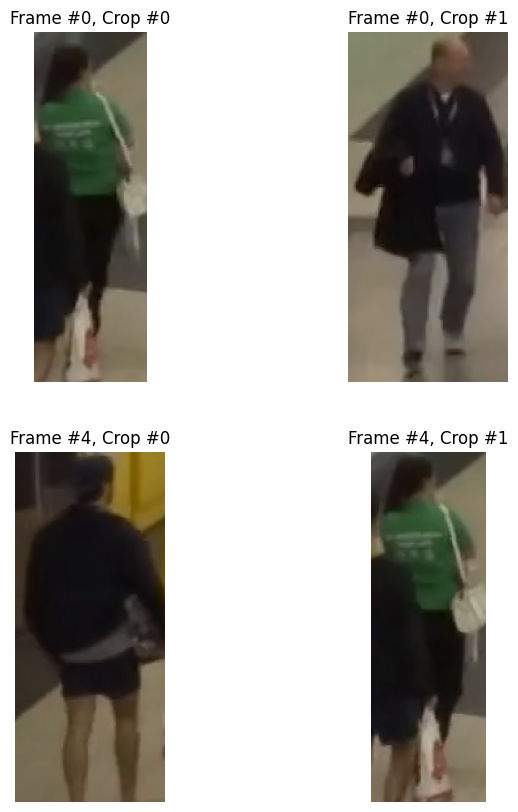

In [17]:
# Get two early frames of video
vid = cv2.VideoCapture('./mot20-01.mp4')
_, first_frame = vid.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
for x in range(3):
    vid.read()
_, second_frame = vid.read()
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)

# Get first maskrcnn detection of first two frames
first_frame_det = all_detections[0].astype(np.int32)
second_frame_det = all_detections[1].astype(np.int32)

# Two crops of two frames
tlx, tly, brx, bry = first_frame_det[0]
cropped00 = first_frame[tly:bry, tlx:brx]
tlx, tly, brx, bry = first_frame_det[1]
cropped01 = first_frame[tly:bry, tlx:brx]
tlx, tly, brx, bry = second_frame_det[0]
cropped40 = second_frame[tly:bry, tlx:brx]
tlx, tly, brx, bry = second_frame_det[1]
cropped41 = second_frame[tly:bry, tlx:brx]

def do_show(ax, img, title):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
do_show(axes[0, 0], cropped00, 'Frame #0, Crop #0')
do_show(axes[0, 1], cropped01, 'Frame #0, Crop #1')
do_show(axes[1, 0], cropped40, 'Frame #4, Crop #0')
do_show(axes[1, 1], cropped41, 'Frame #4, Crop #1')

In [18]:
#@title Task solution

def get_features(cropped):
    return np.concatenate([
        cropped.mean(axis=(0, 1)),
        cropped.std(axis=(0, 1))
    ])

crop00_features = get_features(cropped00)
crop01_features = get_features(cropped01)
crop40_features = get_features(cropped40)
crop41_features = get_features(cropped41)

In [ ]:
#@title Task solution

def get_features(cropped):
    return np.concatenate([
        cropped.mean(axis=(0, 1)),
        cropped.std(axis=(0, 1))
    ])

crop00_features = get_features(cropped00)
crop01_features = get_features(cropped01)
crop40_features = get_features(cropped40)
crop41_features = get_features(cropped41)

We now have a feature vector to represent all four crops. That is, we have mapped the crops to a 6D point in "feature space". We have already shown you how to measure the distance between points.

**Task**: Use `np.linalg.norm()` to measure the distance between each crop on frame 0 and each crop on frame 4 in feature space using vectorisation.

In [19]:
#@title Task solution

frame_0_crop_features = np.stack([crop00_features, crop01_features])
frame_4_crop_features = np.stack([crop40_features, crop41_features])
dist = np.linalg.norm(frame_0_crop_features[:, None] - frame_4_crop_features[None], axis=-1)
print(dist)
print(dist[0, 1])


[[23.86746138  3.85200478]
 [43.62849858 25.22607549]]
3.8520047797450383


In [ ]:
#@title Task solution

frame_0_crop_features = np.stack([crop00_features, crop01_features])
frame_4_crop_features = np.stack([crop40_features, crop41_features])
dist = np.linalg.norm(frame_0_crop_features[:, None] - frame_4_crop_features[None], axis=-1)
print(dist)
print(dist[0, 1])

**Question**: Which pair of crops have the most similar image features? What does this tell us?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

We can see that dist[0, 1] is the smallest diff. This tells us that crop \#0 from frame \#0 is most similar to crop \#1 from frame \#4. We can visually check that this answer makes sense. It is clear that these crops show the same woman with a green shirt and white handbag. This tells us that these detections should belong to the same track.
</details>

<details>
<summary style='cursor:pointer;'><u>Extra details: Other image features</u></summary>

We've only used very simple image features for this. In theory, you can use any image features to describe your crops, but so long as you map all of your crops into the same feature space, you can always calculate the distance between them the same way.
</details>

<details>
<summary style='cursor:pointer;'><u>Extra details: Euclidean distance in image</u></summary>

We generally don't want to completely ignore where the crops are in an image, else we may join bounding boxes on the other side of the image. So, we could typically use a linear combination of the Euclidean distance and appearance feature distance. e.g. `cost = 0.5*euclidean_distance + 0.5*feature_distance`. Intuitively we are saying "crops that are close and look similar should belong together". The exact proportion of each is not standardised.
</details>

<br />

## 4.2 Minimal cost

Now that we have described methods for measuring the cost for associating a detection to a track, we need to describe a method for selecting which detection to attach to each track. But, hold on, that's easy, isn't it? Just choose the smallest cost, right? It turns out to not be quite that simple.

### 4.2.1 Greedy

A greedy algorithm is one which looks at the available options and iteratively picks the smallest cost. This does not work well for association in general. Let's explore an example to see why. Suppose we have these detections:

In [20]:
detections = np.array([
    [[0, 1], [4, 1]],
    [[4, 4], [8, 4]],
])

cost = np.linalg.norm(detections[0][:, None] - detections[1][None], axis=-1)
print(cost)

[[5.         8.54400375]
 [3.         5.        ]]


The smallest distance is `cost[1, 0]`, which is saying the "best" option is to join `detections[0][1]` (i.e. `[4, 1]`) with `detections[1][0]` (`[4, 4]`). So, using a greedy approach we would create a track: `[[4,1], [4,4]]`. Then, we would be left joining the remaining two points into a second track `[[0, 1], [8, 4]]`. But those are really far away! Here's a visualisation of what we just did.

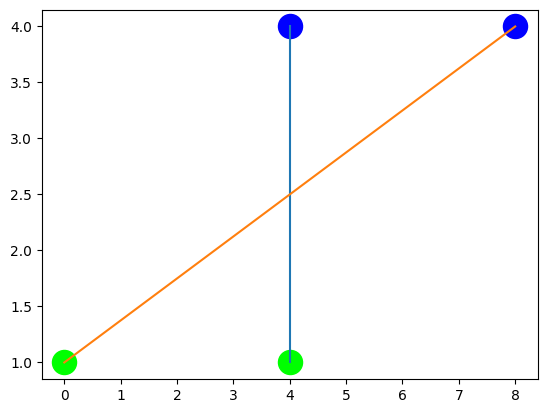

In [21]:
# Draw detections as dots
N = len(detections)
for i, coords in enumerate(detections):
    x, y = xy_separate(coords)
    g = i % 2
    plt.scatter(x, y, color=(0, (1-g), g), s=300)

track1 = {'first_frame': 0, 'points': [[4, 1], [4, 4]]}
track2 = {'first_frame': 0, 'points': [[0, 1], [8, 4]]}

# Draw line
x, y = xy_separate(track1['points'])
plt.plot(x, y)
x, y = xy_separate(track2['points'])
_ = plt.plot(x, y)

Oh dear! That doesn't look right. The problem is that when you greedily assign detections to tracks, you can be left only with very bad options after you've used the best ones. Let's look again at the cost matrix.

In [22]:
print(cost)
print('The total cost with a greedy approach: ', cost[1, 0] + cost[0, 1])
print('The optimum total cost:                ', cost[0, 0] + cost[1, 1])

[[5.         8.54400375]
 [3.         5.        ]]
The total cost with a greedy approach:  11.54400374531753
The optimum total cost:                 10.0


We can see that the cost of putting `[0, 1]` in the same track as `[5, 2]` is so large that it outweighs the benefit of choosing to put `[3, 1]` with `[2, 2]`. To resolve this we will need to find a globally optimum assignment.

### 4.2.2 Linear Assignment Problem

Outside of tracking, this problem has already been studied, and good algorithms proposed to solve this. It is known as a [Linear Assignment Problem](https://en.wikipedia.org/wiki/Assignment_problem).

<details>
<summary style='cursor:pointer;'><u>Extra details: Other names</u></summary>

This problem is very generic, finding uses well outside the realm of computer vision. The scipy function is called `linear_sum_assignment`, and it says that it implements a solution to "minimum weight matching in bipartite graphs". The problem can also be formulated as something called a minimum cost flow network, but the solution is the same for this formulation.
</details>
<br />

**Task**: Use the [`scipy.optimize.linear_sum_assignment()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html) to find the globally optimal assignments. Use the result to assign the `detections[1]` to the correct `tracks`.

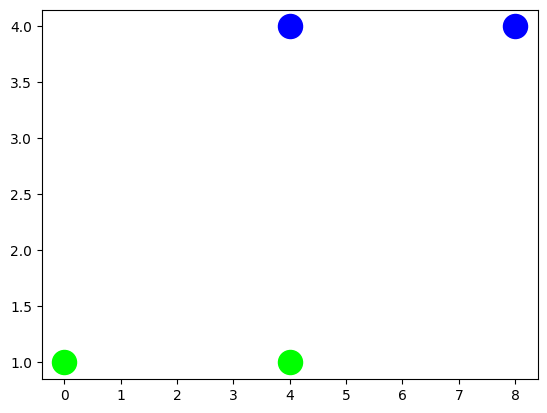

In [23]:
tracks = [
    {'start_frame': 0, 'points':[detections[0][0]]},
    {'start_frame': 0, 'points':[detections[0][1]]},
]
# TODO: use scipy.optimize.linear_sum_assignment to add points from detections[1]


# Draw detections as dots
N = len(detections)
for i, coords in enumerate(detections):
    x, y = xy_separate(coords)
    g = i % 2
    plt.scatter(x, y, color=(0, (1-g), g), s=300)

# Draw line
x, y = xy_separate(tracks[0]['points'])
plt.plot(x, y)
x, y = xy_separate(tracks[1]['points'])
_ = plt.plot(x, y)

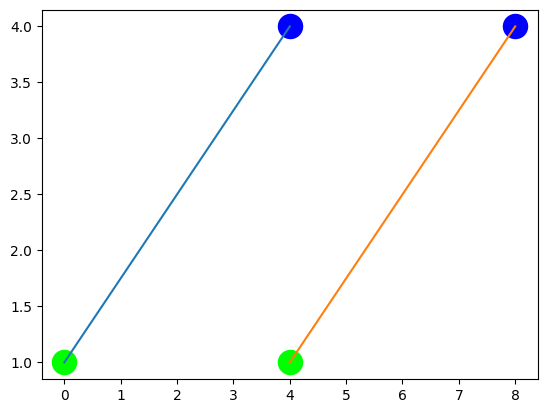

In [24]:
#@title Task solution

tracks = [
    {'start_frame': 0, 'points':[detections[0][0]]},
    {'start_frame': 0, 'points':[detections[0][1]]},
]
rows, cols = scipy.optimize.linear_sum_assignment(cost)
for r, c in zip(rows, cols):
    tracks[r]['points'].append(detections[1][c])

# Draw detections as dots
N = len(detections)
for i, coords in enumerate(detections):
    x, y = xy_separate(coords)
    g = i % 2
    plt.scatter(x, y, color=(0, (1-g), g), s=300)

# Draw line
x, y = xy_separate(tracks[0]['points'])
plt.plot(x, y)
x, y = xy_separate(tracks[1]['points'])
_ = plt.plot(x, y)

## 4.3 Pulling association together

We can measure the cost and use that to associate boxes using what we've learned.

**Task**: Implement a function that associates a set of the last boxes of some tracks with a set of detections. You may choose to use Bounding box center distance or Bounding box overlap as your cost metric. *Hint*: A low cost implies a good match, so be careful with IoU, which is high for a good match.

In [ ]:
def associate(track_boxes, det_boxes):
    '''
    Find association indices between track_boxes and det_boxes.

    Args:
        track_boxes (np.array): last box of tracks shaped [N, 4] using tlx, tly, brx, bry
        det_boxes (np.array): detections on this frame shaped [M, 4] using tlx, tly, brx, bry
    Returns:
        row_ind, col_ind: np.array output of scipy.optimize.linear_sum_assignment
    '''
    pass

# These are from 4.1.3
detections = [
    [0.1, 0.1, 0.2, 0.2],
    [0.3, 0.1, 0.5, 0.2],
    [0.2, 0.5, 0.3, 0.7],
    [0.6, 0.2, 0.9, 0.3],
]
tracks = [
    {'start_frame': 0, 'boxes': [
        [0.08, 0.08, 0.18, 0.18],
        [0.09, 0.09, 0.19, 0.19],
    ]},
    {'start_frame': 0, 'boxes': [
        [0.22, 0.52, 0.32, 0.72],
        [0.21, 0.51, 0.31, 0.71],
    ]},
]
detections_np = np.array(detections)
previous_np = np.array([t['boxes'][-1] for t in tracks])
rows, cols = associate(previous_np, detections_np)
for r, c in zip(rows, cols):
    tracks[r]['boxes'].append(detections[c])
print(tracks)

In [25]:
#@title Task solution

def associate(track_boxes, det_boxes):
    '''
    Find association indices between track_boxes and det_boxes.

    Args:
        track_boxes (np.array): last box of tracks shaped [N, 4] using tlx, tly, brx, bry
        det_boxes (np.array): detections on this frame shaped [M, 4] using tlx, tly, brx, bry
    Returns:
        row_ind, col_ind: np.array output of scipy.optimize.linear_sum_assignment()
    '''
    # Solution 1 - bounding box centers
    track_points = np.array(tlbr_to_center(track_boxes))
    det_points = np.array(tlbr_to_center(det_boxes))
    cost = np.linalg.norm(track_points[:, None] - det_points[None], axis=-1)

    # Solution 2 - bounding box IoU
    cost = (1-bbox_iou_matrix(track_boxes, det_boxes))

    return scipy.optimize.linear_sum_assignment(cost)

# These are from 4.1.3
detections = [
    [0.1, 0.1, 0.2, 0.2],
    [0.3, 0.1, 0.5, 0.2],
    [0.2, 0.5, 0.3, 0.7],
    [0.6, 0.2, 0.9, 0.3],
]
tracks = [
    {'start_frame': 0, 'boxes': [
        [0.08, 0.08, 0.18, 0.18],
        [0.09, 0.09, 0.19, 0.19],
    ]},
    {'start_frame': 0, 'boxes': [
        [0.22, 0.52, 0.32, 0.72],
        [0.21, 0.51, 0.31, 0.71],
    ]},
]
detections_np = np.array(detections)
previous_np = np.array([t['boxes'][-1] for t in tracks])
rows, cols = associate(previous_np, detections_np)
for r, c in zip(rows, cols):
    tracks[r]['boxes'].append(detections[c])
print(tracks)

[{'start_frame': 0, 'boxes': [[0.08, 0.08, 0.18, 0.18], [0.09, 0.09, 0.19, 0.19], [0.1, 0.1, 0.2, 0.2]]}, {'start_frame': 0, 'boxes': [[0.22, 0.52, 0.32, 0.72], [0.21, 0.51, 0.31, 0.71], [0.2, 0.5, 0.3, 0.7]]}]


# 5. Implementation

Here we provide a simple tracking implementation that uses your `associate` function.

Sometimes objects appear and disappear from view. When do we say a detection represents something new to have appeared? When do we say something has disappeared? These are difficult questions without a single, optimal answer. We'll take the simplest approach here. If we can't find a detection for a track on the next frame, it gets closed. If we can't find a track for a detection, we open a new track.

**In your own time**: Look at another [simple implementation of tracking](https://github.com/jbencook/pytorch-object-tracking/blob/master/simple-track.py)

In [26]:
def do_tracking(detections):
    ''' Track via detections '''
    open_tracks = []
    closed_tracks = []

    for i, det_boxes in enumerate(detections):
        track_indices = det_indices = []
        if i > 0:
            # Associate det_boxes with the open tracks
            track_boxes = np.array([tracklet["boxes"][-1] for tracklet in open_tracks])
            track_indices, det_indices = associate(track_boxes, det_boxes)

        # Add matches to open tracks
        for track_idx, det_idx in zip(track_indices, det_indices):
            open_tracks[track_idx]["boxes"].append(det_boxes[det_idx])

        # Close lost tracks - tracks without a matching detection
        lost_indices = set(range(len(open_tracks))) - set(track_indices)
        for lost_idx in sorted(lost_indices, reverse=True):
            closed_tracks.append(open_tracks.pop(lost_idx))

        # Open new tracks - detections without a matching track
        new_indices = set(range(len(det_boxes))) - set(det_indices)
        for new_idx in new_indices:
            open_tracks.append(
                {"start_frame": i, "boxes": [det_boxes[new_idx]]}
            )

    return closed_tracks + open_tracks

In [27]:
all_tracks = do_tracking(all_detections)

## 5.1 Visualise

We will now draw the boxes and trajectories onto each frame of the video and visualise the tracking results.

In [28]:
vid = cv2.VideoCapture('./mot20-01.mp4')
vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
vid_out = cv2.VideoWriter('./mot20-01-det.mp4', fourcc, 15, (1920, 1080))

for i in range(vid_length):
    # Read a frame
    _, img = vid.read()

    # For all tracks, draw a box if it has a box on this frame
    for t, track in enumerate(all_tracks):
        # Find the idx within track for this frame
        s_f = track['start_frame']
        inner_idx = i-s_f
        if 0 <= inner_idx < len(track['boxes']):
            # Pull out box dimensions
            tlx, tly, brx, bry = track['boxes'][inner_idx].astype(np.int32)
            # Colour the box based on track index
            colour = COLOURS[t%len(COLOURS)]
            cv2.rectangle(img, (tlx, tly), (brx, bry), color=colour, thickness=2)

    vid_out.write(img)

vid_out.release()

In [29]:
from google.colab import files
files.download('./mot20-01-det.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This code creates a video out of the detections/tracks. Each track is assigned a colour. Try following individual people and see how often the boxes around them change colour. When it changes colour, that means it's lost them and created a new track. Each individual tends to have multiple tracks due to confounding extra detections and missed detections.

**Question**: How would you rate the tracking?

<details>
<summary style='cursor:pointer;'><u>Tutor's answer</u></summary>

It is difficult to separate the detection quality from the tracking quality. The tracking isn't amazing. The people at the edges without much to obscure them tend to be tracked relatively well, but they still get lost a few times, with multiple tracks required to follow them. In the center, where there's lots of people. Each person's tracks only lasts a few seconds at best; there's too many confounding detections. It could be improved with a better tracking algorithm.
</details>

# 6 Velocity prediction

Objects typically move from frame to frame. If we simply use euclidean distance, we run a serious risk of identity swapping. Consider the graph below. The changing colours represent the different frames that the detections are made.

In [ ]:
detections = [
    [[1, 1]],
    [[2, 2]],
    [[3, 3]],
    [[4, 4], [3, 4]],
    [[5, 5]],
    [[6, 6]],
    [[7, 7]],
]

# Draw dots
N = len(detections)
for i, coords in enumerate(detections):
    x, y = xy_separate(coords)
    g = i % 2
    plt.scatter(x, y, color=(0, (1-g), g), s=300)

# Draw line
x = [p[0][0] for p in detections[:3]]
y = [p[0][1] for p in detections[:3]]
_ = plt.plot(x, y)

**Question**: The track represented in the above graph currently has `[(1,1), (2,2), (3,3)]`. It appears that the points are following linear motion. Assuming it is, out of `(3, 4)` and `(4, 4)`, which point is the most correct to add to this track?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The point `(4, 4)` makes the most sense to add to this track, because it seems like the object is moving up and to the right at a steady rate. Notice, however that `(3, 4)` is closer to `(3, 3)` than `(4, 4)` is. So a method of association that does not account for motion will prefer to add `(3, 3)`.

Predicting that the next point in the sequence is `(4, 4)` is called "linear extrapolation".
</details>
<br/>

**Task**: Write a function `predict_next()` that makes a prediction for the next position for all tracks it is given using only the last two points of the track. If the track has only one point, then it should return that point.

In [ ]:
# TODO write function
# def predict_next(tracks):


tracks = [
    {'start_frame': 0, 'points': [
        [1, 1],
        [2, 2],
        [3, 3],
    ]},
    {'start_frame': 0, 'points': [
        [6, 1],
        [5, 2],
        [4, 3],
    ]}
]
predicted_next = predict_next(tracks)
assert predicted_next[0] == [4, 4]
assert predicted_next[1] == [3, 4]

In [ ]:
#@title Task solution

def predict_next(tracks):
    predicted = []
    for track in tracks:
        if len(track['points']) == 1:
            predicted.append(track['points'][0])
        else:
            # Convert to numpy array just to make the maths simpler
            p_2 = np.array(track['points'][-2])
            p_1 = np.array(track['points'][-1])
            p_n = p_1 + (p_1-p_2)
            predicted.append(p_n.tolist())
    return predicted

## 6.1 Other methods to predict the next location

Linear extrapolation using the last two points is the simplest method of estimating the next position for a track. Other methods for predicting the next point include:
 - Using momentum
 - Kalman filter
 - Neural network

The most common method is the Kalman Filter. Exploring the Kalman Filter is outside the scope of this lab.

# 7. Aspects not covered

Tracking suffers from being simple enough in a single case, but highly complex in the general case. There are a million different ways to describe the problem and there are a million different ways that a tracker can fail.

Some issues with the above implementation in order of easy to solve to hard to solve:
* It assumes all boxes are the same class.
* Object velocity is ignored. Even using perfect detections, it will tend to swap identity when paths intersect.
* It only uses points; this makes it faster and simpler, but theoretically a tracking algorithm that could look at the appearance of the detections should more accurate.
* If an individual is completely missed for a single frame, it will either end the track, or jump to another individual.
* The linear assignment is unconstrained. Imagine a single existing track on the left of the image, and a single new point detected on the right of the image. This point will be attached to that track, even though the distance is clearly too far to be the same object.
* We have described a relatively greedy "online" tracking algorithm. That is, it runs iteratively and builds up tracks in a single pass of the data. This requires the least information. There are other tracking methods which take a more global approach to tracking, and use graphs to find a minimum cost association across the entire collection of detections which are theoretically more optimal.
* Distances between objects in the foreground are treated the same as distances between objects in the background. Moving 10 pixels vertically in an image typically represents a larger physical distance than 10 pixels horizontally.

There's a lot of variation between tracking algorithms; we have shown you just one way to do it.

We also haven't touched evaluating tracking algorithms.

# Challenge Tasks

## Challenge Task 1 - Solve aspects not covered

Solve the first three issues in the above list.

### Same class

*Hint:* Store the detections per-class. Run tracking on each predicted class.

### Velocity

*Hint:* Instead of using the last position utilise linear extrapolation from the last two points of the track (if it exists) to predict the next location. The only change required is that you calculate the matrix created for the linear assignment problem differently.

### Appearance features

*Hint:* Use the technique shown in 4.1.4 to compare detections. Measure the "distance" between the track and the points as a balance between euclidean distance and appearance similarity. The only change required is that you calculate the matrix created for the linear assignment problem differently.

## Challenge Task 2 - Use deep learning features

We have previously noted that deep learning models have "automatic feature extraction". Then, if we want image features for something other than classification, one option is to leverage existing deep learning model's feature extraction. This is a common way to produce appearance features for matching in tracking.

**Task**: Create an instance of the `mobilenet_v3` model from `torchvision`. Load the first frame of the video `mot20-01.mp4`. Get the maskrcnn detections for the first frame of the video. Use the first detection to crop the first frame of the video to only a single person. Call `preprocess_image()` from lab 3 on the crop, and give the result to the `mobilenet_v3.features()` function. Give the result of that to `mobilenet_v3.avgpool()`.

**Question**: How many features does `mobilenet_v3` reduce the crop to after `avgpool()`? *Hint*: After `avgpool`, the shape will be in BCHW.

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The output of `avgpool()` has 576 channels, and a height/width of 1. Thus there are 576 features.
</details>

In [ ]:
# From Lab 3
def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = tvtf.resize(image, 256)
    image = tvtf.center_crop(image, 224)
    image = tvtf.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image.unsqueeze(dim=0)
    return image

# TODO: Get dl model


# TODO: Get first frame of video


# TODO: Get first maskrcnn detection of first frame


# TODO: Crop first frame and prepare for model


# TODO: Extract appearance features of crop using model

print(dl_features.shape)

In [ ]:
#@title Task solution

# Get dl model
mobilenet_v3 = torchvision.models.mobilenet_v3_small(pretrained=True)

# Get first frame of video
vid = cv2.VideoCapture('./mot20-01.mp4')
_, first_frame = vid.read()

# Get first maskrcnn detection of first frame
first_det = all_detections[0][0].astype(np.int32)
tlx, tly, brx, bry = first_det

# Crop first frame  and prepare for model
cropped = first_frame[tly:bry, tlx:brx]
preprocessed = preprocess_image(cropped)

# Extract features using model
dl_features_0 = mobilenet_v3.features(preprocessed)
dl_features = mobilenet_v3.avgpool(dl_features_0)
print(dl_features.shape)

# Summary

In this lab we have described the core parts of tracking by detections, shown one simple implementation of tracking and visually evaluated using MaskRCNN with this tracking algorithm on a short video.